# Data Mining & Machine Learning - Regression Part 2

### Case 2: Prediction of Footballer Values with Supervised Learning

83109 Samuel Didovic<br>
86368 Isabel Lober<br>
85915 Pascal Seitz<br>

Lecturer: Prof. Dr. Adrian Moriariu

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl

In [3]:
# Loading the data
filename = "football_cleaned"

# Data folder
data_dir = "football-data"

file_path = f"{data_dir}/{filename}.csv"

# Read the CSV file directly, specifying the delimiter and thousands separator
df = pd.read_csv(file_path, delimiter=',', thousands=',')

In [4]:
df.head()

,player,position,squad,age,birth_year,value,height,foot,league,games,...,CL,WinCL,CLBestScorer,Season,year,player_year_id,nationality_code,positions_played,position_type,specific_position
0,Burgui,"FW,MF",Alavés,23.0,1993.0,1800000.0,186.0,right,La Liga,23.0,...,0.0,0.0,0.0,201718#,2017,1_2017,ESP,2,Attack,Left-Winger
1,Raphaël Varane,DF,Real Madrid,24.0,1993.0,70000000.0,191.0,right,La Liga,27.0,...,1.0,1.0,0.0,201718#,2017,2_2017,FRA,1,Defender,Centre-back
2,Rubén Duarte,DF,Alavés,21.0,1995.0,2000000.0,179.0,left,La Liga,24.0,...,0.0,0.0,0.0,201718#,2017,3_2017,ESP,1,Defender,Left-back
3,Samuel Umtiti,DF,Barcelona,23.0,1993.0,60000000.0,182.0,left,La Liga,25.0,...,1.0,0.0,0.0,201718#,2017,4_2017,FRA,1,Defender,Centre-back
4,Manu García,MF,Alavés,31.0,1986.0,1800000.0,183.0,left,La Liga,30.0,...,0.0,0.0,0.0,201718#,2017,5_2017,ESP,1,Midfield,Defensive-Midfield


In [5]:
# Identifying non-numeric features
non_numeric_features = df.select_dtypes(include=['object', 'category']).columns

print(non_numeric_features)

Index(['player', 'position', 'squad', 'foot', 'league', 'Season',
       'player_year_id', 'nationality_code', 'position_type',
       'specific_position'],
      dtype='object')


In [6]:
# Setting the player_year_id as the index of the DataFrame
df.set_index('player_year_id', inplace=True)

In [7]:
columns_to_drop = ['player', 'birth_year', 'Season', 'value', 'year', 'Attendance', 'position']  # Columns to drop from the dataset 

X = df.drop(columns_to_drop, axis=1)  # Drop target and any non-predictive columns
y = df['value']  # Target variable

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_and_scale_data(X, y, test_size=0.2, random_state=42):
    """
    Splits data into training and testing sets and scales the target variable.

    Parameters:
    - X (DataFrame or array): Features dataset.
    - y (Series or array): Target variable.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Controls the shuffling applied to the data before applying the split.

    Returns:
    - X_train, X_test, y_train_scaled, y_test_scaled: Training and testing sets with scaled target variable.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler to the training data and transform it
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

    # Transform the test data using the same scaler
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

    return X_train, X_test, y_train_scaled, y_test_scaled


In [9]:
# Prepare and scale the data
X_train, X_test, y_train_scaled, y_test_scaled = prepare_and_scale_data(X, y)

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

# Create transformers for categorical and numerical data
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

numerical_transformer = Pipeline([
    ('scaler', StandardScaler())  # Standardizing numerical features
])

# Define the pipeline with proper column selectors
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, make_column_selector(dtype_include=np.number)),  # Automatically selects numerical columns
            ('cat', categorical_transformer, make_column_selector(dtype_include=['object', 'category']))  # Automatically selects categorical columns
        ], remainder='passthrough')),
    ('regressor', GradientBoostingRegressor(random_state=42))
])


In [11]:
from skopt.space import Real, Integer
from skopt import BayesSearchCV

def perform_bayesian_optimization(pipeline, X_train, y_train, param_space, n_iter=32, cv=3, scoring='neg_mean_squared_error'):
    """
    Perform Bayesian optimization to find the best hyperparameters for the given pipeline.

    Parameters:
    - pipeline: A scikit-learn Pipeline object.
    - X_train: Training feature data.
    - y_train: Training target data.
    - param_space: Dictionary defining the hyperparameter search space.
    - n_iter: Number of iterations for the Bayesian search.
    - cv: Cross-validation splitting strategy.
    - scoring: Strategy to evaluate the performance of the cross-validated model on the train data.

    Returns:
    - best_params: Dictionary of the best parameters found.
    - opt: BayesSearchCV object after fitting (optional).
    """

    # Create the BayesSearchCV object
    opt = BayesSearchCV(pipeline, param_space, n_iter=n_iter, scoring=scoring, cv=cv, n_jobs=-1, verbose=1)

    # Fit the model
    opt.fit(X_train, y_train)

    return opt.best_params_, opt

# Example of how to define the parameter space externally:
# param_space = {
#     'regressor__n_estimators': Integer(50, 500),
#     'regressor__max_depth': Integer(3, 10),
#     'regressor__learning_rate': Real(0.01, 1.0, 'log-uniform'),
#     'regressor__min_samples_split': Integer(2, 10),
#     'regressor__min_samples_leaf': Integer(1, 10)
# }


We already ran a parameter search for the default model (model without special preprocessing or feature engineering). It took:


Best Parameters:
{
    
    "regressor__learning_rate": 0.0584827020656369,
    "regressor__max_depth": 5,
    "regressor__min_samples_leaf": 6,
    "regressor__min_samples_split": 2,
    "regressor__n_estimators": 381
}

Best Score (Negative MSE):  
    
    -73902805336975.61


However, will call again but with low iteration. The ranges will be set around the already determined parameters.

In [12]:
# Example of how to define the parameter space externally:
param_space = {
    'regressor__n_estimators': Integer(380, 382),
    'regressor__max_depth': Integer(5, 6),
    'regressor__learning_rate': Real(0.058, 0.59, 'log-uniform'),
    'regressor__min_samples_split': Integer(2, 3),
    'regressor__min_samples_leaf': Integer(6, 7)
}

best_params, opt = perform_bayesian_optimization(pipeline, X_train, y_train_scaled, param_space, n_iter=1, cv=3, scoring='neg_mean_squared_error')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [51]:
import json

def write_optimization_results_to_file(best_params, best_score, suffix='default.txt'):
    """
    Writes the best parameters and the best score from a model optimization process to a text file in a readable format.

    Parameters:
    - best_params: A dictionary containing the best parameters found during the optimization.
    - best_score: The best score achieved during the optimization.
    - suffix: A string to append to the file name to differentiate between different optimization results.
    """
    # Convert the best_params to a string - in a human-readable format using json.dumps
    params_str = json.dumps(best_params, indent=4)
    
    # Write the best parameters and other details to a text file
    file_name = "optimization_results_" + suffix
    with open(file_name, 'w') as file:
        file.write("Best Parameters:\n")
        file.write(params_str + "\n")
        
        # Write the best score if needed
        file.write(f"Best Score (Negative MSE): {best_score}\n")
    
    # Print confirmation that the file has been written
    print(f"Optimization results have been written to '{file_name}'.")

In [ ]:
write_optimization_results_to_file(best_params, opt.best_score_)

In [12]:
# Prepare parameters in the form required by scikit-learn estimators
# This typically involves removing any prefixes and adapting parameter names correctly
use_best_params = False
if use_best_params:
    estimator_params = {k.replace("regressor__", ""): v for k, v in best_params.items()}
else:
    # Default parameters
    estimator_params = {
        'n_estimators': 381,
        'max_depth': 5,
        'learning_rate': 0.0584827020656369,
        'min_samples_split': 2,
        'min_samples_leaf': 6
    }
    
# Update the pipeline regressor with the best parameters
pipeline.set_params(regressor__n_estimators=estimator_params['n_estimators'],
                         regressor__learning_rate=estimator_params['learning_rate'],
                         regressor__max_depth=estimator_params['max_depth'],
                         regressor__min_samples_split=estimator_params['min_samples_split'],
                         regressor__min_samples_leaf=estimator_params['min_samples_leaf'])

# Now fit the pipeline with updated parameters to the scaled training data
pipeline.fit(X_train, y_train_scaled)

# Optionally, evaluate the model after training
y_pred = pipeline.predict(X_test)


In [13]:
# Evaluate the model
obj = pipeline # Define the object to be used for evaluation
y_test_pred = obj.predict(X_test)
y_train_pred = obj.predict(X_train)

y_test_pred, y_train_pred

(array([-0.25384761,  0.07586877, -0.6177789 , ..., -0.41535487,
        -0.01447323, -0.44979967]),
 array([-0.39761947, -0.39569773, -0.01667914, ...,  0.37704605,
        -0.52487707,  1.03704761]))

In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate

def evaluate_regression_model(y_train, y_train_pred, y_test, y_test_pred):
    """
    Evaluates the performance of a regression model by calculating and displaying
    several common metrics in a formatted table.
    
    Parameters:
    - y_train (array-like): Actual target values for the training set.
    - y_train_pred (array-like): Predicted target values for the training set.
    - y_test (array-like): Actual target values for the test set.
    - y_test_pred (array-like): Predicted target values for the test set.
    
    Returns:
    - A dictionary containing the calculated metrics for both the training and testing sets.
    """
    
    # Calculate the metrics
    metrics = {
        "Mean Squared Error (MSE)": [mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
        "Mean Absolute Error (MAE)": [mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)],
        "Root Mean Squared Error (RMSE)": [np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_test_pred))],
        "R-squared": [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]
    }
    
    # Prepare the data for tabulation
    table = [["Metric", "Train", "Test"]]
    for metric, values in metrics.items():
        table.append([metric, f"{values[0]:.2f}", f"{values[1]:.2f}"])
    
    # Print the table
    print(tabulate(table, headers="firstrow", tablefmt="github"))

    return metrics

default_eval = evaluate_regression_model(y_train_scaled, y_train_pred, y_test_scaled, y_test_pred)

| Metric                         |   Train |   Test |
|--------------------------------|---------|--------|
| Mean Squared Error (MSE)       |    0.03 |   0.2  |
| Mean Absolute Error (MAE)      |    0.11 |   0.25 |
| Root Mean Squared Error (RMSE) |    0.16 |   0.45 |
| R-squared                      |    0.97 |   0.77 |


In [15]:
def plot_predictions(y_train, y_train_pred, y_test, y_test_pred, suffix=""):
    """
    Plots the actual vs. predicted values for training and testing datasets.

    Parameters:
    - y_train: Actual values from the training set.
    - y_train_pred: Predicted values for the training set.
    - y_test: Actual values from the testing set.
    - y_test_pred: Predicted values for the testing set.
    - suffix: An optional suffix to add to the plot title for clarity. Start with a space.
    """

    plt.figure(figsize=(14, 8))  # Set up the figure with a larger size for better visibility

    # Plot test predictions in blue
    plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5, edgecolor='k', label='Test Predictions')
    # Plot training predictions in red
    plt.scatter(y_train, y_train_pred, color='red', alpha=0.5, edgecolor='k', label='Train Predictions')
    # Add a line of perfect prediction
    plt.plot([0, max(y_test.max(), y_train.max())], [0, max(y_test.max(), y_train.max())], 
             color='black', linestyle='--', label='Perfect Prediction')

    # Adding titles and labels
    plt.title(f'Actual vs. Predicted Values:{suffix}', fontsize=20)
    plt.xlabel('Actual Values', fontsize=16)
    plt.ylabel('Predicted Values', fontsize=16)

    # Add a grid for better readability
    plt.grid(True)

    # Add a legend to explain which markers are which
    plt.legend(title="Legend", title_fontsize='13', fontsize='12', loc='upper left')
    plt.tight_layout()
    
    # Format the suffix to be file and title appropriate
    formatted_suffix = suffix.strip().replace(" ", "_").lower()
    
    plt.savefig(f'actual_vs_predicted_{formatted_suffix}.png')
    # Show the plot
    plt.show()

def plot_histograms(y_actual, y_predicted):
    """
    Plots histograms of actual and predicted values for comparison.
    This function uses consistent styling with other visualization functions in the analysis,
    focusing on using blue for actual values and red for predicted values to maintain visual consistency.

    Parameters:
    - y_actual (array-like): Actual target values.
    - y_predicted (array-like): Predicted target values.
    """
    
    fig, ax = plt.subplots(figsize=(14, 8))  # Use the same figure size as the plot_predictions for consistency
    
    # Plot histogram of actual values
    ax.hist(y_actual, bins=30, alpha=0.5, color='blue', label='Actual', edgecolor='black')
    
    # Plot histogram of predicted values
    ax.hist(y_predicted, bins=30, alpha=0.5, color='red', label='Predicted', edgecolor='black')
    
    # Adding titles and labels with improved formatting to match plot_predictions
    ax.set_xlabel('Value', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    ax.set_title('Histogram of Actual and Predicted Values', fontsize=20)
    
    # Add a grid for better readability, matching the style in plot_predictions
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Improve the legend with fontsize and location
    ax.legend(title="Legend", title_fontsize='13', fontsize='12', loc='upper right')
    
    # Show the plot
    plt.show()

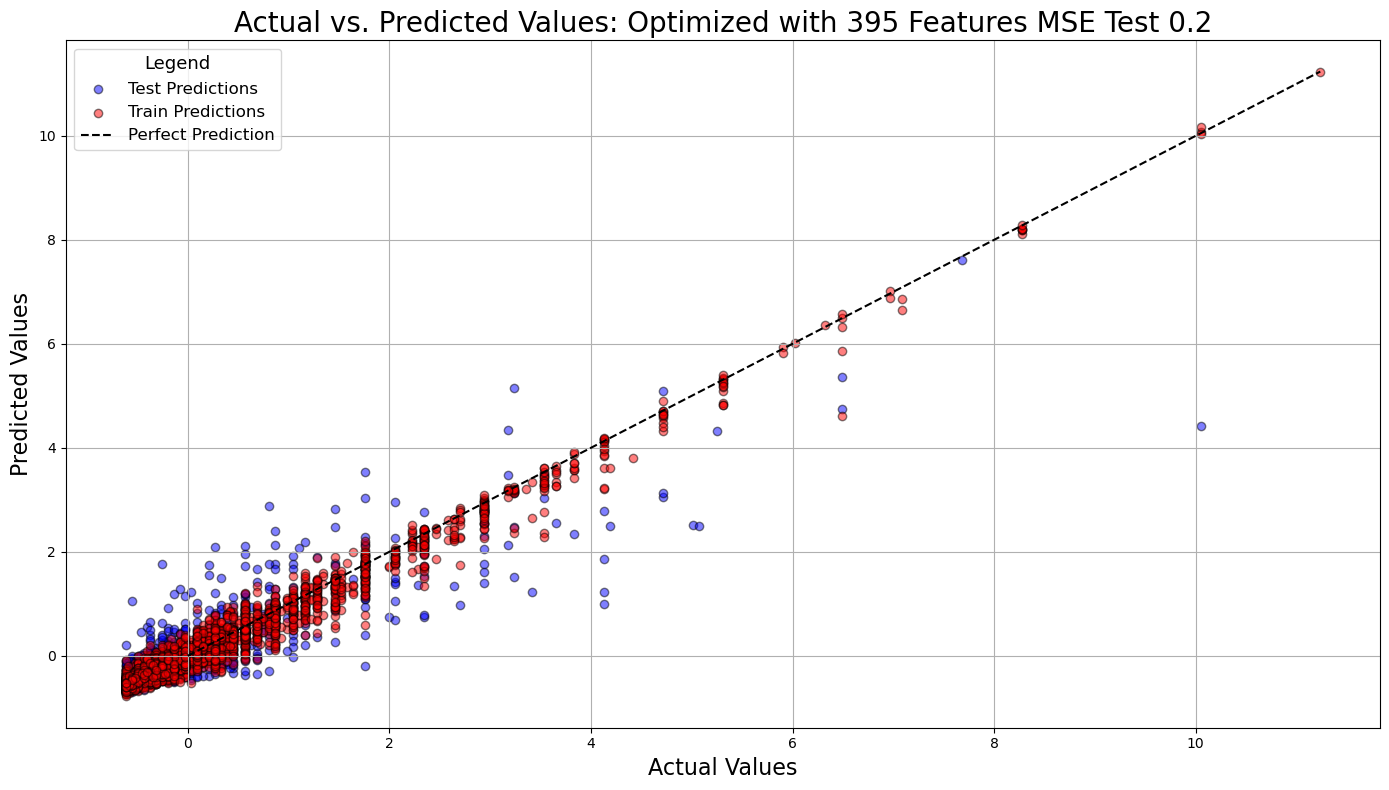

In [81]:
plot_predictions(y_train_scaled, y_train_pred, y_test_scaled, y_test_pred, suffix=f" Optimized with {len(X.columns)} Features MSE Test {np.round(default_eval['Mean Squared Error (MSE)'][1], 2)}")

### Feature Name Extraction Post-Preprocessing

After preprocessing, the original feature names may not correspond directly to the model's input features due to transformations like one-hot encoding, which expands categorical features into multiple binary features. Here's how to handle this in your pipeline:

#### Access the ColumnTransformer
- **Retrieve the ColumnTransformer**: This component contains all transformers applied to subsets of features, both numerical and categorical.

#### Iterate Over Transformers
- **Loop through each transformer** within the ColumnTransformer. These apply specific transformations to selected columns. For transformers like `OneHotEncoder` that alter the number of features, it's essential to retrieve the new feature names.

#### Handle OneHotEncoder
- **OneHotEncoder**: For categorical features processed by `OneHotEncoder`, use `get_feature_names_out()` to retrieve the new names, which are formatted as `<feature_name>_<category>` for clarity.

#### StandardScaler and Passthrough
- **StandardScaler**: Features processed remain with their original names, as this transformer does not alter feature identity.
- **Passthrough**: Directly use the original names for any columns set to "passthrough," which are not transformed at all.

These steps ensure that you can accurately map the feature importances output by your model to the appropriate transformed feature names, enhancing the interpretability of your model's predictions.


In [17]:
# Extracting the feature importances from the regressor within the pipeline
feature_importances = pipeline.named_steps['regressor'].feature_importances_

# Access the preprocessor step in your pipeline
preprocessor = pipeline.named_steps['preprocessor']

# Initialize an empty list to store feature names
feature_names = []

# Iterate over all transformers within the ColumnTransformer
for transformer_name, transformer, columns in preprocessor.transformers_:
    if transformer_name == 'remainder':
        # Process remainder which could be 'passthrough' or another transformer
        if transformer == 'passthrough':
            # If 'passthrough', the original feature names in these columns are added
            feature_names.extend(columns)
    else:
        if hasattr(transformer, 'named_steps'):
            # Access the final step of each sub-pipeline in the transformer
            transformer = transformer.named_steps[list(transformer.named_steps.keys())[-1]]
        
        if hasattr(transformer, 'get_feature_names_out'):
            # For transformers with this method (like OneHotEncoder)
            if isinstance(columns, slice):
                transformer_feature_names = transformer.get_feature_names_out(preprocessor.feature_names_in_[columns])
            else:
                transformer_feature_names = transformer.get_feature_names_out(columns)
            feature_names.extend(transformer_feature_names)
        else:
            # For transformers that do not modify feature names (like StandardScaler), just add the original names
            feature_names.extend(columns)

In [95]:
# Create a DataFrame of features and their importance
features_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame to see the most important features at the top
features_importance = features_importance.sort_values(by='Importance', ascending=False)

In [96]:
features_importance.head(50)

,Feature,Importance
26,shots_on_target,0.111033
379,Pts,0.109440
131,pass_targets,0.067803
0,age,0.066323
373,W,0.055032
385,CL,0.051420
126,players_dribbled_past,0.039268
5,goals,0.023427
524,league_Premier League,0.022616
47,passes_completed_long,0.019157


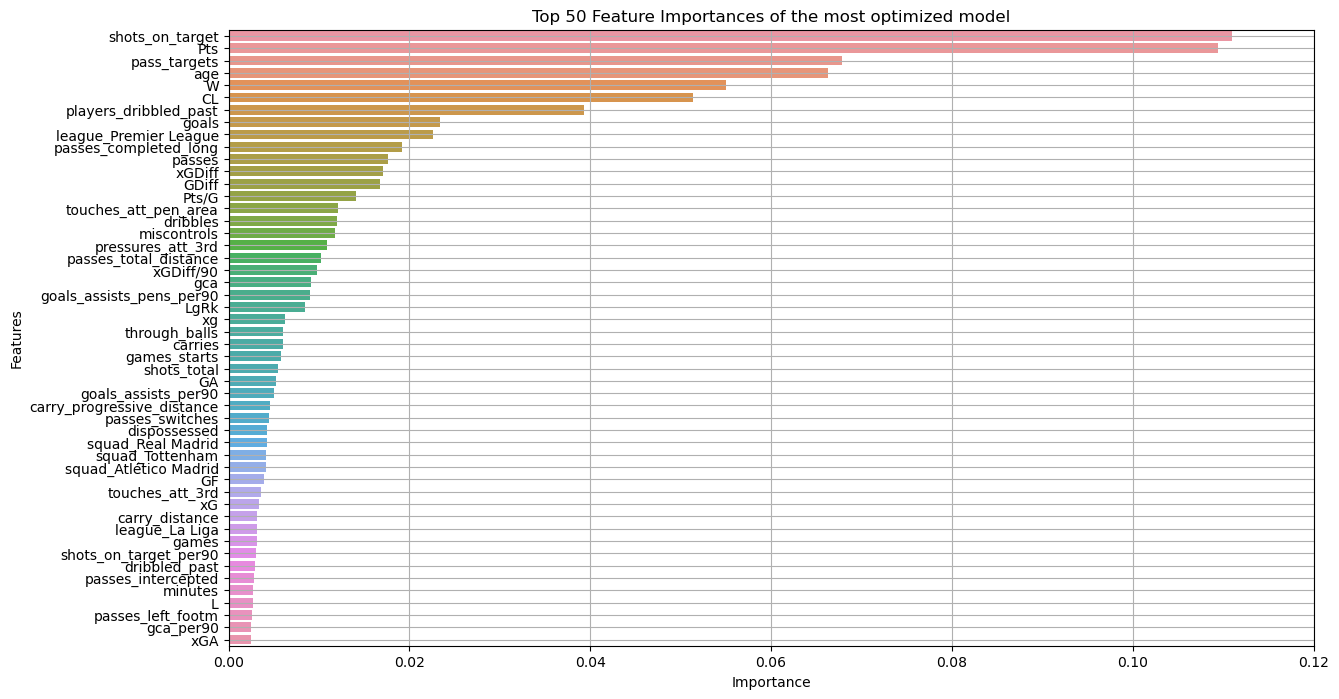

In [73]:
def plot_feature_importances(features_importance, top_n=50):
    """
    Plots the top N feature importances for a given model.

    Parameters:
    - features_importance: A DataFrame containing the features and their importances.
                            The DataFrame should have columns named 'Feature' and 'Importance'.
    - top_n: The number of top features to display. Default is 50.
    """
    # Prepare the figure
    plt.figure(figsize=(14, 8))

    # Plot the top N features
    sns.barplot(data=features_importance.head(top_n), x='Importance', y='Feature')

    # Set the title and labels
    plt.title('Top 50 Feature Importances of the most optimized model')
    plt.xlabel('Importance')
    plt.ylabel('Features')

    # Set the x-ticks to improve readability
    plt.xticks(np.arange(0, features_importance['Importance'].max() + 0.01, 0.02))

    # Add a grid for better readability
    plt.grid(True)

    # Show the plot
    plt.show()
    
plot_feature_importances(features_importance)

In [20]:
def get_top_n_correlated_features(X, y, n=10):
    """
    Calculates the correlation of all features with a target variable and returns the top n features.
    Assumes target data is not in the DataFrame and is provided separately.

    Parameters:
    - X (DataFrame): The dataset containing features.
    - y (Series): The target variable data.
    - n (int): Number of top features to return based on correlation.

    Returns:
    - top_features (Series): Top n features sorted by their correlation magnitude with the target.
    """

    # Temporarily concatenate the target data for correlation calculation
    numerical_columns = X.select_dtypes(include=[np.number]).columns
    df_temp = X.copy()
    df_temp = df_temp[numerical_columns]
    df_temp['target'] = y

    # Calculate the correlation matrix
    correlation_matrix = df_temp.corr().abs()

    # Extract the correlations with the target variable
    target_correlation = correlation_matrix['target']

    # Remove the target variable from the series to avoid self-correlation
    target_correlation = target_correlation.drop('target', errors='ignore')

    # Sort the features by absolute correlation values in descending order
    top_features = target_correlation.abs().sort_values(ascending=False).head(n)

    # Convert the series to DataFrame for better formatting and add column names
    top_features_df = top_features.reset_index()
    top_features_df.columns = ['Feature', 'Correlation']
    
    return top_features_df

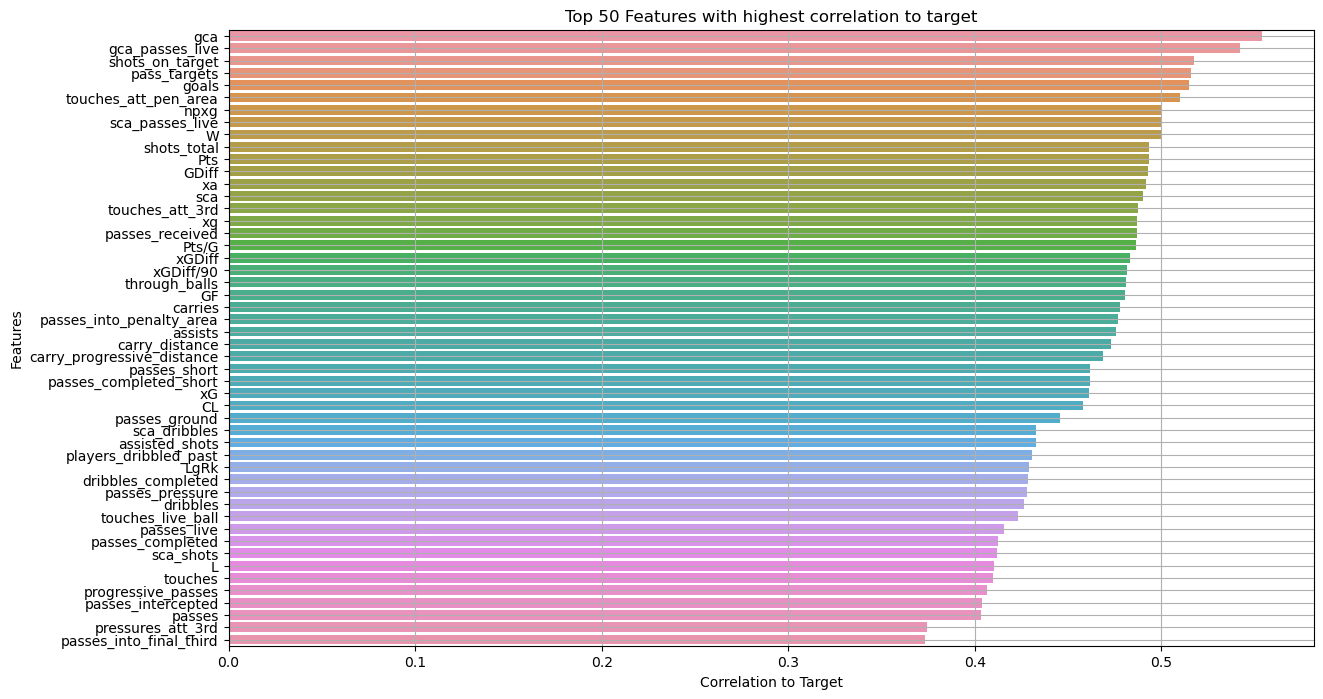

In [21]:
features_by_corr = get_top_n_correlated_features(X, y, n = 50)

plt.figure(figsize=(14, 8))
sns.barplot(data=features_by_corr, x="Correlation",y="Feature")
plt.title('Top 50 Features with highest correlation to target')
plt.xlabel('Correlation to Target')
plt.ylabel('Features')
# Add a grid for better readability
plt.grid(True)
# Show the plot
plt.show()

In [104]:
def remove_unimportant_features(X, features_importance, importance_threshold=0.01):
    """
    Removes features from the dataset that do not meet the importance threshold. This function ignores
    any transformations that might happen later in a pipeline.

    Parameters:
    - X (DataFrame): The original dataset with all features.
    - features_importance (DataFrame): A DataFrame containing feature names and their importances.
    - importance_threshold (float): The threshold for determining if a feature is important.

    Returns:
    - X_reduced (DataFrame): The dataset with only the important features retained.
    """
    # Ensure the feature names in features_importance are in the columns of X
    relevant_importances = features_importance[features_importance['Feature'].isin(X.columns)]

    # Filter out features that have an importance less than the threshold
    important_features = relevant_importances[relevant_importances['Importance'] >= importance_threshold]['Feature']

    # Reduce the dataset to only include important features
    X_reduced = X[important_features.tolist()]

    return X_reduced, important_features

# Example usage:
importance_threshold = 0.005 # Define a threshold for feature importance
X_reduced, important_features = remove_unimportant_features(X, features_importance, importance_threshold)
print("Reduced dataset shape:", X_reduced.shape)

Reduced dataset shape: (6592, 29)


In [105]:
# Split the reduced dataset into training and testing sets
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = prepare_and_scale_data(X_reduced, y, test_size=0.2, random_state=42)

In [106]:
param_space = {
    'regressor__n_estimators': Integer(300, 600),
    'regressor__max_depth': Integer(4, 7),
    'regressor__learning_rate': Real(0.01, 0.05, 'log-uniform'),
    'regressor__min_samples_split': Integer(2, 8),
    'regressor__min_samples_leaf': Integer(2, 8)
}#

best_params, opt = perform_bayesian_optimization(pipeline, X_train_reduced, y_train_reduced, param_space, n_iter=32, cv=5, scoring='neg_mean_squared_error')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [107]:
# Predict the target values using the optimized pipeline
y_test_pred_reduced = opt.predict(X_test_reduced)
y_train_pred_reduced = opt.predict(X_train_reduced)

In [108]:
write_optimization_results_to_file(best_params, opt.best_score_, suffix=f'reduced_{len(X_reduced.columns)}.txt')

reduced_eval = evaluate_regression_model(y_train_scaled, y_train_pred_reduced, y_test_scaled, y_test_pred_reduced)

Optimization results have been written to 'optimization_results_reduced_29.txt'.
| Metric                         |   Train |   Test |
|--------------------------------|---------|--------|
| Mean Squared Error (MSE)       |    0.04 |   0.23 |
| Mean Absolute Error (MAE)      |    0.13 |   0.27 |
| Root Mean Squared Error (RMSE) |    0.2  |   0.48 |
| R-squared                      |    0.96 |   0.74 |


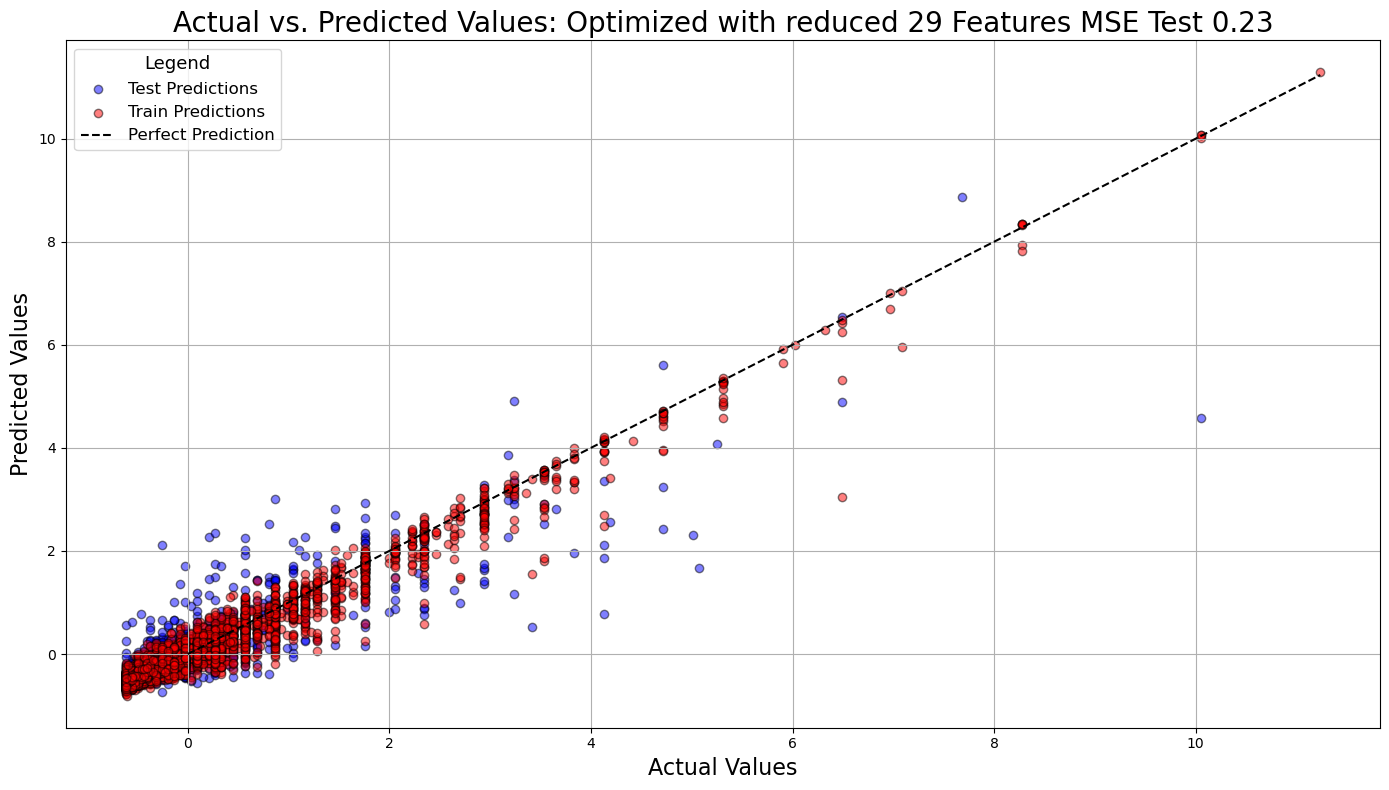

In [109]:
plot_predictions(y_train_scaled, y_train_pred_reduced, y_test_scaled, y_test_pred_reduced, suffix=f" Optimized with reduced {len(X_reduced.columns)} Features MSE Test {np.round(reduced_eval['Mean Squared Error (MSE)'][1], 2)}")

# Comparisson of results

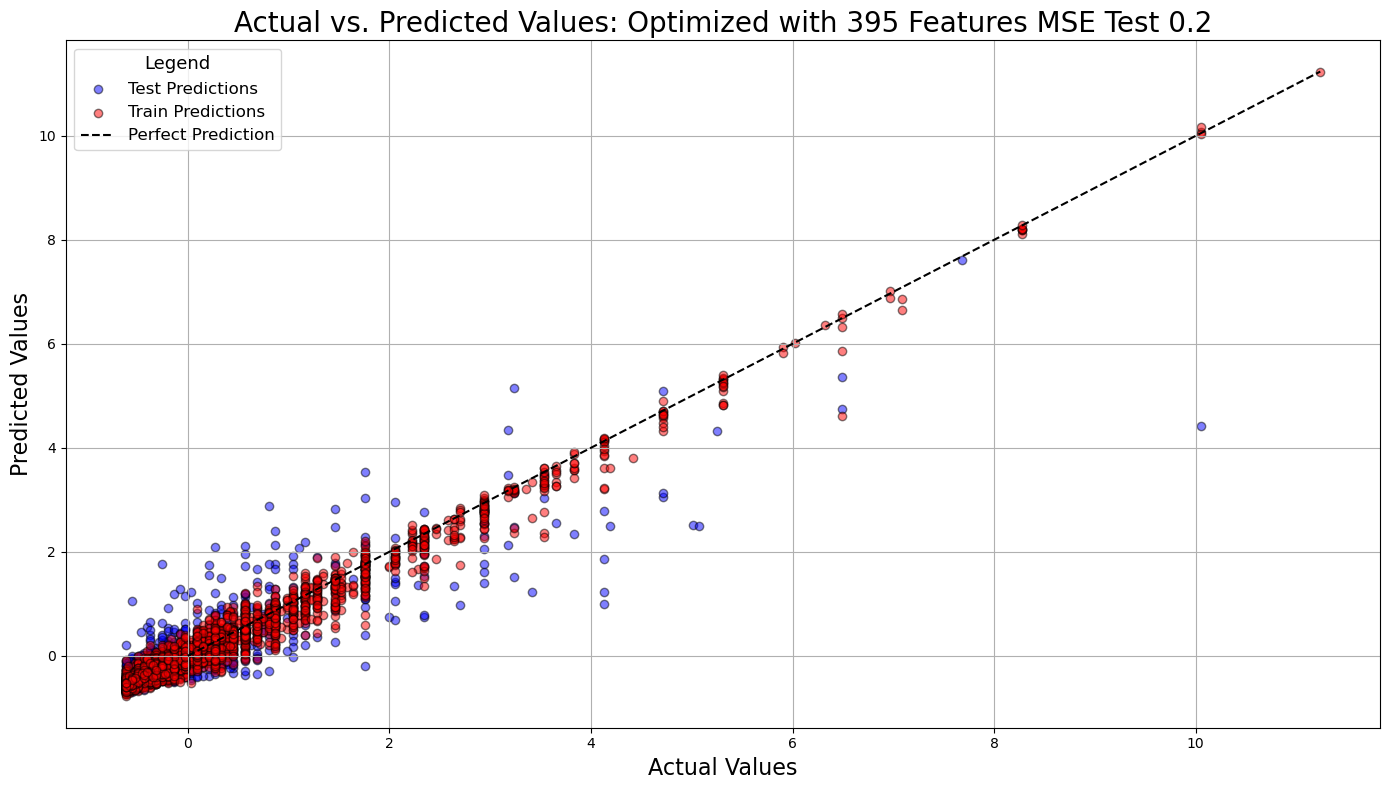

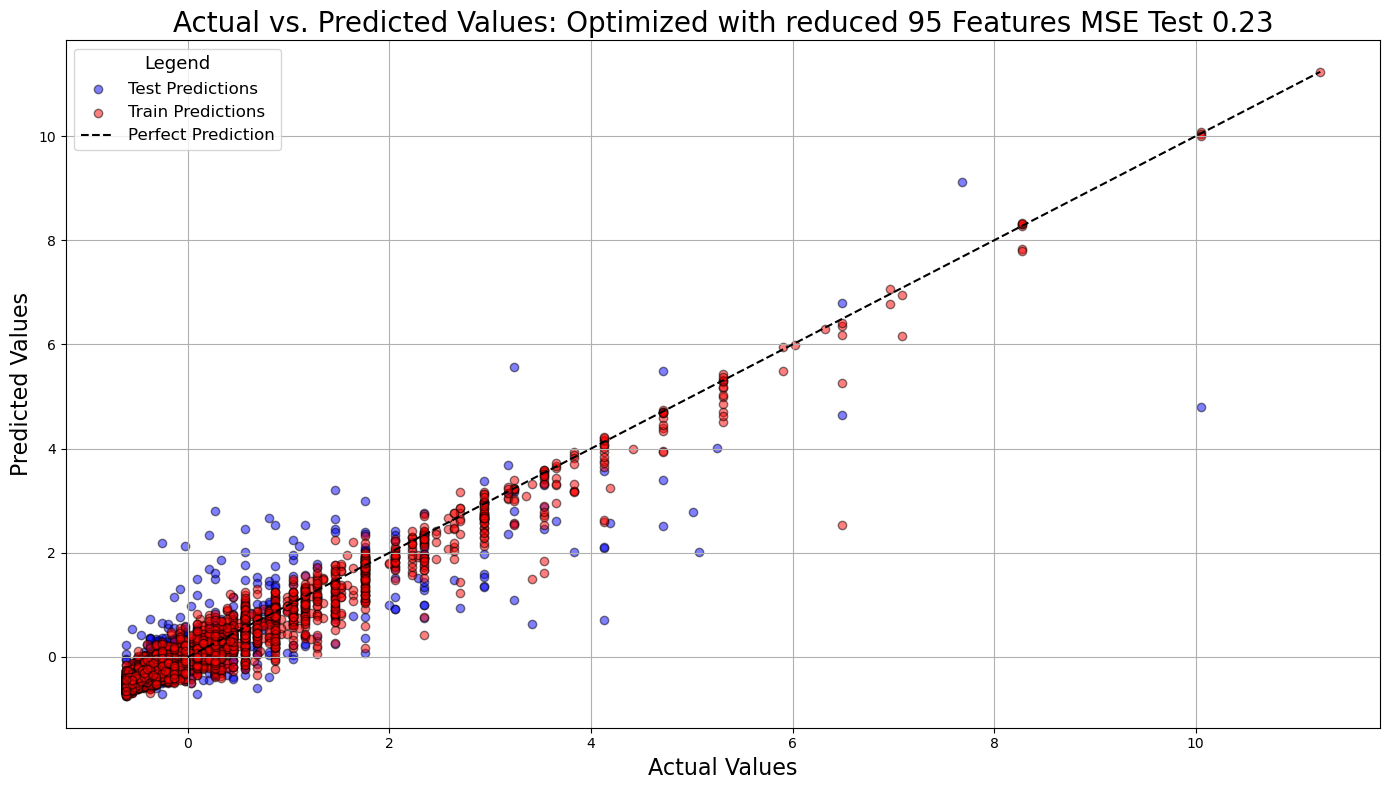

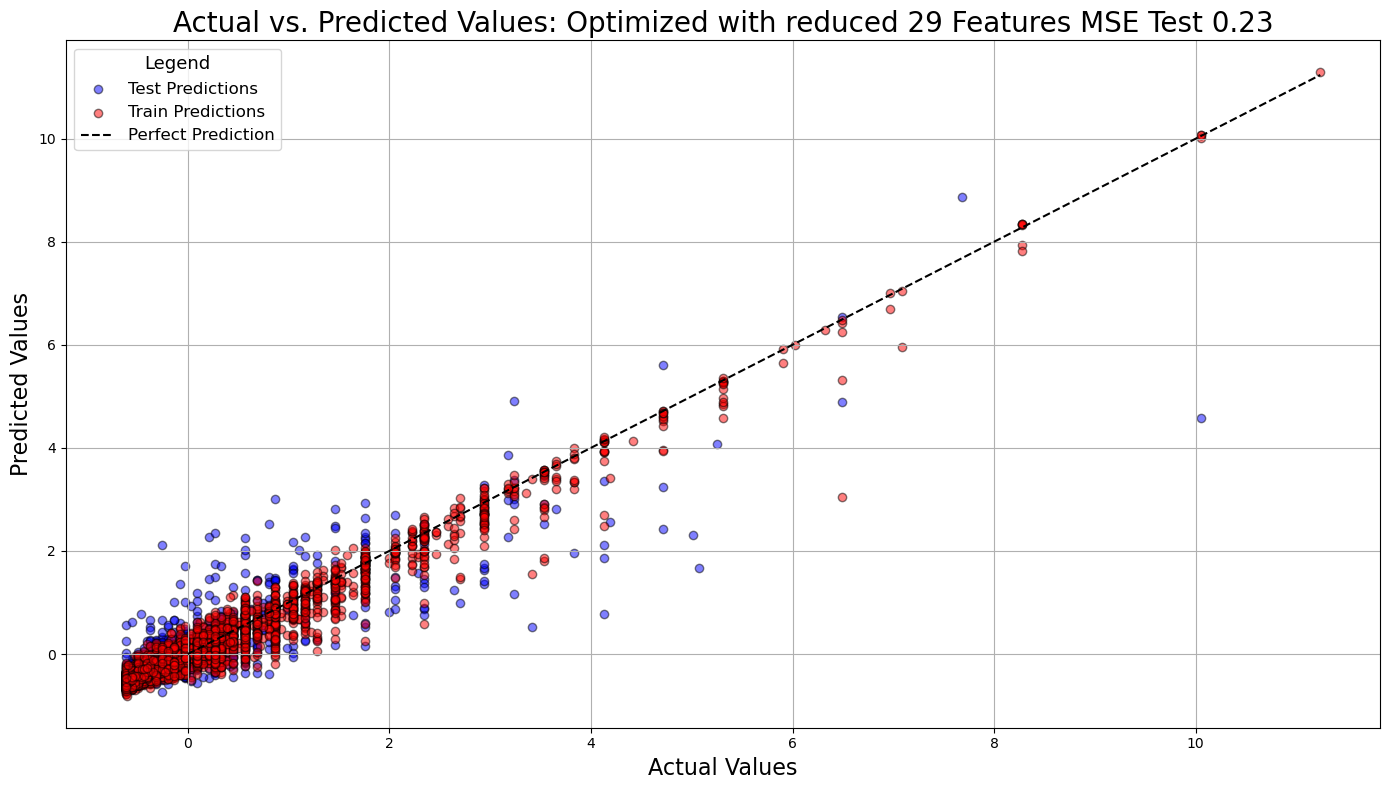

In [98]:
def caluclate_error_per_samples(y_test, y_pred):
    """
    Calculate the error per sample between the actual and predicted values.

    Parameters:
    - y_test: Actual target values.
    - y_pred: Predicted target values.

    Returns:
    - error_per_sample: The error per sample between the actual and predicted values.
    """
    # Calculate the error per sample
    error_per_sample = np.abs(y_test - y_pred)
    
    return error_per_sample

,shots_on_target,Pts,pass_targets,age,W,CL,players_dribbled_past,goals,passes_completed_long,passes,...,gca,goals_assists_pens_per90,LgRk,xg,through_balls,carries,games_starts,shots_total,GA,goals_assists_per90
player_year_id,,,,,,,,,,,,,,,,,,,,,
1209_2018,0.0,47.0,32.0,30.0,11.0,0.0,0.0,0.0,65.0,793.0,...,0.0,0.00,12.0,0.1,0.0,29.0,16.0,1.0,50.0,0.00
3638_2019,0.0,56.0,520.0,24.0,16.0,0.0,1.0,0.0,241.0,910.0,...,0.0,0.00,6.0,0.1,0.0,547.0,25.0,1.0,48.0,0.00
1090_2018,0.0,44.0,8.0,22.0,11.0,0.0,0.0,0.0,6.0,22.0,...,0.0,0.00,15.0,0.0,0.0,6.0,1.0,0.0,66.0,0.00
966_2017,21.0,29.0,1206.0,29.0,6.0,0.0,47.0,9.0,42.0,921.0,...,5.0,0.58,18.0,7.6,3.0,891.0,26.0,60.0,76.0,0.58
2589_2018,3.0,49.0,356.0,19.0,11.0,0.0,24.0,2.0,39.0,351.0,...,1.0,0.30,11.0,0.8,0.0,373.0,10.0,12.0,48.0,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506_2018,14.0,61.0,823.0,21.0,15.0,1.0,50.0,5.0,40.0,655.0,...,11.0,0.49,4.0,2.1,7.0,712.0,18.0,35.0,35.0,0.49
2125_2018,9.0,38.0,696.0,20.0,9.0,0.0,38.0,1.0,14.0,352.0,...,2.0,0.12,15.0,2.7,1.0,463.0,15.0,34.0,52.0,0.12
725_2017,21.0,41.0,1010.0,34.0,11.0,0.0,37.0,5.0,49.0,610.0,...,7.0,0.30,12.0,5.8,2.0,709.0,22.0,44.0,43.0,0.30
